# Exercise 3. Linear regression for saturated and superheated vapor properties prediction

The data is taken from this book: Introduction to Chemical Engineering Thermodynamics by J. M. Smith, H. C. Van Ness and M. M. Abbott, 7th Edition. Appendix F.

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
#%matplotlib inline 

### Import data from the .csv file
 First step is always important: **check your raw data**.

In [2]:
data = pd.read_csv("Data_superheated_vapor_training.csv")  # Import superheated vapor data
data.head()                                       # Preview the first 5 lines of the loaded data

,Pressure,Property,Liq_Sat,Vap_Sat,75,100,125,150,175,200,...,425,450,475,500,525,550,575,600,625,650
0,1.0,V,1.000,129200.0000,160640.0000,172180.0000,183720.0000,195270.0000,206810.0000,218350.0000,...,NaN,333730.00,NaN,356810.0000,NaN,379880.0000,NaN,402960.0000,NaN,426040.0000
1,1.0,U,29.334,2385.2000,2480.8000,2516.4000,2552.3000,2588.5000,2624.9000,2661.7000,...,NaN,3049.90,NaN,3132.4000,NaN,3216.7000,NaN,3302.6000,NaN,3390.3000
2,1.0,H,29.335,2514.4000,2641.5000,2688.6000,2736.0000,2783.7000,2831.7000,2880.1000,...,NaN,3383.60,NaN,3489.2000,NaN,3596.5000,NaN,3705.6000,NaN,3816.4000
3,1.0,S,0.106,8.9767,9.3828,9.5136,9.6365,9.7527,9.8629,9.9679,...,NaN,10.82,NaN,10.9612,NaN,11.0957,NaN,11.2243,NaN,11.3476
4,10.0,V,1.010,14670.0000,16030.0000,17190.0000,18350.0000,19510.0000,20660.0000,21820.0000,...,NaN,33370.00,NaN,35670.0000,NaN,37980.0000,NaN,40290.0000,NaN,42600.0000


### Separate the data according to the property

Since, we have different thermophysical properties, it make sense (at this step) to separate the data into each one of them to build independent models for each one of those. After this, **ploting the data** is always useful. So, let's see what shapes we are dealing with, what trend the data follows, etcetera.

In [3]:
V_data = data.loc[data['Property'] == 'V']
U_data = data.loc[data['Property'] == 'U']
H_data = data.loc[data['Property'] == 'H']
S_data = data.loc[data['Property'] == 'S']

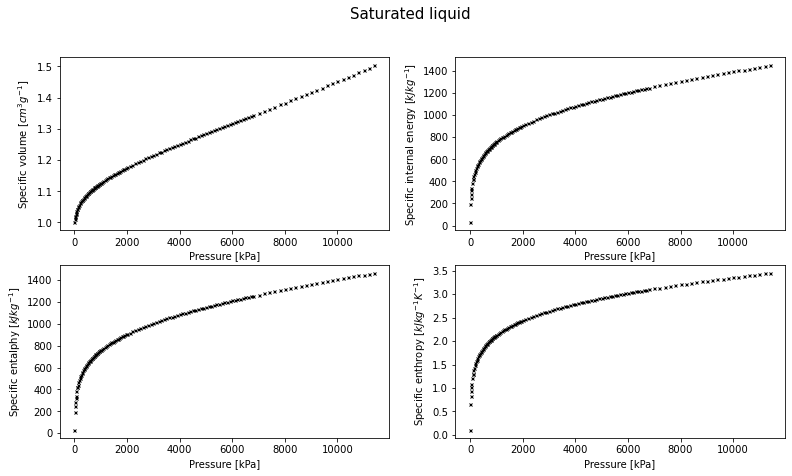

In [4]:
# Plot saturated liquid
plt.figure(figsize=(13, 7))
plt.subplot(221)
plt.plot(V_data['Pressure'], V_data['Liq_Sat'], 'kx', markersize=3)
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific volume [$cm^3 g^{-1}$]')

plt.subplot(222)
plt.plot(U_data['Pressure'], U_data['Liq_Sat'], 'kx', markersize=3)
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific internal energy [$kJ kg^{-1}$]')

plt.subplot(223)
plt.plot(H_data['Pressure'], H_data['Liq_Sat'], 'kx', markersize=3)
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific entalphy [$kJ kg^{-1}$]')

plt.subplot(224)
plt.plot(S_data['Pressure'], S_data['Liq_Sat'], 'kx', markersize=3)
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific enthropy [$kJ kg^{-1} K^{-1}$]')

plt.suptitle('Saturated liquid', size=15)
plt.show()

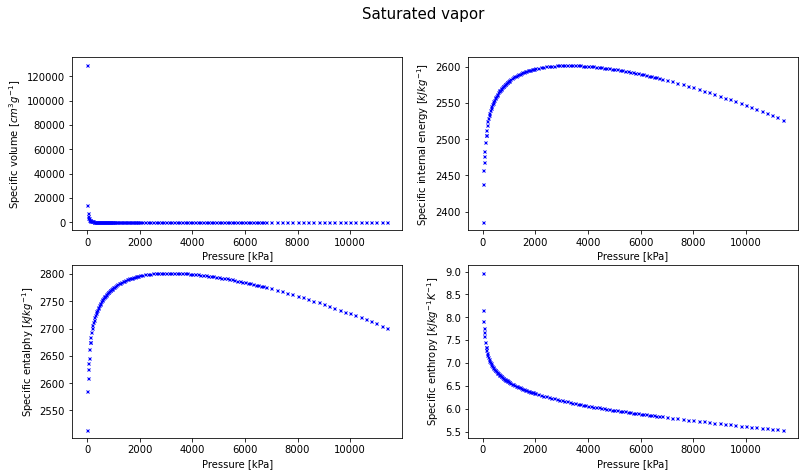

In [5]:
# Similarly you can try yourself to Plot saturated vapor Data
plt.figure(figsize=(13, 7))
plt.subplot(221)
plt.plot(V_data['Pressure'], V_data['Vap_Sat'], 'bx', markersize=3)
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific volume [$cm^3 g^{-1}$]')

plt.subplot(222)
plt.plot(U_data['Pressure'], U_data['Vap_Sat'], 'bx', markersize=3)
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific internal energy [$kJ kg^{-1}$]')

plt.subplot(223)
plt.plot(H_data['Pressure'], H_data['Vap_Sat'], 'bx', markersize=3)
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific entalphy [$kJ kg^{-1}$]')

plt.subplot(224)
plt.plot(S_data['Pressure'], S_data['Vap_Sat'], 'bx', markersize=3)
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific enthropy [$kJ kg^{-1} K^{-1}$]')

plt.suptitle('Saturated vapor', size=15)
plt.show()

### For this exercise lecture, let's work with the specific volume of the saturated liquid

Our goal is to build a mathematical model (simple linear regression for now), that predicts the specific volume of a saturated vapor as a function of the pressure. First, we need to realize that a simple line is not going to fit well the whole range of pressures (THIS IS THE IMPORTANCE OF LOOKING AT YOUR DATA FIRST!). Therefore, let's generate some subranges to approximate the experimental data using linear regression.

#### Plot specific volume of saturated liquid with subranges

I suggest something like this.

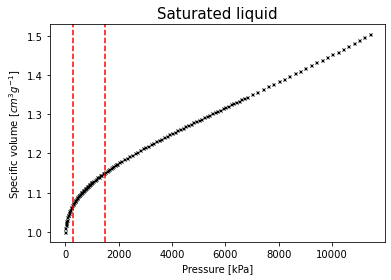

In [6]:
plt.figure()
plt.plot(V_data['Pressure'], V_data['Liq_Sat'], 'kx', markersize=3)
plt.axvline(1500, linestyle='--', color='r')
plt.axvline(300, linestyle='--', color='r')
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific volume [$cm^3 g^{-1}$]')
plt.title('Saturated liquid', size=15)
plt.show()

#### Therefore, let's split our data further to get each one of those sections

In [7]:
First_P  = V_data['Pressure'].loc[V_data['Pressure'] < 300] 
First_V  = V_data['Liq_Sat'].loc[V_data['Pressure'] < 300]

Second_P = V_data['Pressure'].loc[(V_data['Pressure'] >= 300) & 
                                  (V_data['Pressure'] < 1500)]
Second_V = V_data['Liq_Sat'].loc[(V_data['Pressure'] >= 300) & 
                                  (V_data['Pressure'] < 1500)]

Third_P  = V_data['Pressure'].loc[V_data['Pressure'] >= 1500]
Third_V  = V_data['Liq_Sat'].loc[V_data['Pressure'] >= 1500]

In [8]:
type(First_P)

pandas.core.series.Series

#### We will use [sklearn for linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

**Note:** We can also use numpy library (Mathematical operations) to define the optimization problem of Linear regression by writting all the equations from the scratch whereas sklearn has already defined LinearRegression function in which all those equations are coded in standard form and we can solve any Linear Regression problem by just writting few lines of code.

#### You can also try to write the equations from scratch using numpy library and compare the results with sklearn automatic implementation for better understanding.

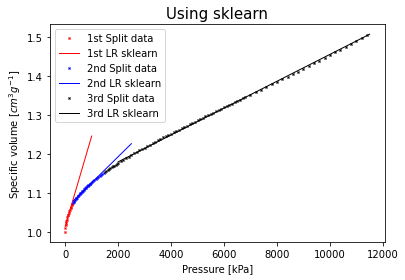

In [9]:
# Let's use sklearn, and code everything in a couple of lines
LR_sklearn_1 = LinearRegression().fit(np.array(First_P).reshape(-1, 1), First_V)
LR_sklearn_2 = LinearRegression().fit(np.array(Second_P).reshape(-1, 1), Second_V)
LR_sklearn_3 = LinearRegression().fit(np.array(Third_P).reshape(-1, 1), Third_V)

# - Plot splits and models
plt.figure()
plt.title('Using sklearn', size=15)
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific volume [$cm^3 g^{-1}$]')

# -- First split
plt.plot(First_P, First_V, 'rx', markersize=2, label='1st Split data')    # Traning data
plt.plot(np.linspace(0,1000, 100), LR_sklearn_1.predict(np.linspace(0,1000, 100).reshape(-1, 1)),'r', linewidth=1,
         label='1st LR sklearn')  # Using sklearn

# -- Second split
plt.plot(Second_P, Second_V, 'bx', markersize=2, label='2nd Split data')  # Using sklearn
plt.plot(np.linspace(300,2500, 100), LR_sklearn_2.predict(np.linspace(300,2500, 100).reshape(-1, 1)),'b', linewidth=1, 
         label='2nd LR sklearn')  # Using sklearn


# -- Third split
plt.plot(Third_P, Third_V, 'kx', markersize=2, label='3rd Split data')    # Using sklearn
plt.plot(np.linspace(2000,11500, 100), LR_sklearn_3.predict(np.linspace(2000,11500, 100).reshape(-1, 1)),'k', linewidth=1,
         label='3rd LR sklearn')  # Using sklearn

plt.legend()
plt.show()

#### We can check how well our model is fitting our training data by printing the $R^2$ coefficient

The coefficient $R^2$ is defined as $1 - \frac{u}{v}$, where $u$ is the residual sum of squares $\sum (y_{true} - y_{pred})^2$ and $v$ is the total sum of squares $\sum (y_{true} - y_{true}^{mean})^2$. The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of $y$, disregarding the input features, would get a $R^2$ score of 0.0.

In [10]:
# -- Let's print the R**2 to get an idea of how well our model is fitting the data
print('\n R2 for 1st split:', LR_sklearn_1.score(np.array(First_P).reshape(-1, 1), First_V))
print('\n R2 for 2nd split:', LR_sklearn_2.score(np.array(Second_P).reshape(-1, 1), Second_V))
print('\n R2 for 3rd split:', LR_sklearn_3.score(np.array(Third_P).reshape(-1, 1), Third_V))


 R2 for 1st split: 0.9263208134364597

 R2 for 2nd split: 0.9870087187227413

 R2 for 3rd split: 0.9990370407798591


#### We can also check the parameter values

In [11]:
# -- You can also have access to the parameters of the LR in sklearn
print('\n Slope for 1st split    :', LR_sklearn_1.coef_)
print(' Intercept for 1st split:', LR_sklearn_1.intercept_)

print('\n Slope for 2nd split    :', LR_sklearn_2.coef_)
print(' Intercept for 2nd split:', LR_sklearn_2.intercept_)

print('\n Slope for 3rd split    :', LR_sklearn_3.coef_)
print(' Intercept for 3rd split:', LR_sklearn_3.intercept_)


 Slope for 1st split    : [0.00023137]
 Intercept for 1st split: 1.0143878627679743

 Slope for 2nd split    : [6.67710359e-05]
 Intercept for 2nd split: 1.0592155742277978

 Slope for 3rd split    : [3.44236231e-05]
 Intercept for 3rd split: 1.1107246430495454


### Now, let's work with our superheated vapor data

In our data set, we have a bunch of data corresponding to superheated vapor. We can take a look into it to see how can we create a mathematical model for it, in order to use it later for process simulation or process optimization. For this first exercise lecture, let's work with the enthalpy.

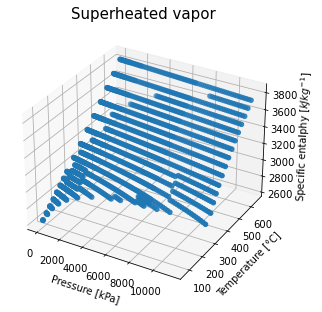

In [12]:
# - First, let's plot the data available to see if we can observe certain pattern

#%matplotlib qt

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
x = H_data['Pressure']
y = np.array([int(H_data.columns[4:][i]) for i in range(len(H_data.columns[4:]))])     # for loop is used to visit every element and to make it integer type
X,Y = np.meshgrid(x,y)
Z = H_data.loc[:, '75':'650']

ax.scatter(X, Y, Z.T)
ax.set_xlabel('Pressure [kPa]')
ax.set_ylabel('Temperature [°C]')
ax.set_zlabel('Specific entalphy [$kJ kg^{-1}$]')
ax.set_title('Superheated vapor', size=15)
plt.show()

#### It seems like a multivariate linear regression would fit our experimental data quite well

Let's jump and use sklearn directly

In [13]:
P   = X.reshape(-1,1)
T   = Y.reshape(-1,1)
P_T = np.append(P, T, axis=1) 
H   = np.array(Z.T).reshape(-1,1)

# -- Clean data to eliminate NaN which cannot be used to fit the LR
H_bool  = np.isnan(H)
P_clean = np.zeros(len(P)-np.count_nonzero(H_bool))
T_clean = np.zeros(len(P_clean))
H_clean = np.zeros(len(P_clean))
j = 0

for i in range(P.shape[0]):
    if H_bool[i] == False:
        P_clean[j] = P[i]
        T_clean[j] = T[i]
        H_clean[j] = H[i]
        j += 1

P_T_clean = np.append(P_clean.reshape(-1,1), T_clean.reshape(-1,1), axis=1)       
LR_SV     = LinearRegression().fit(P_T_clean, H_clean)

# -- R2 score
print('\n R2 for LR_SV:', LR_SV.score(P_T_clean, H_clean))


 R2 for LR_SV: 0.9876784909472981


In [14]:
# -- You can also have access to the parameters of the LR in sklearn
print('\n Slope for 1st split    :', LR_SV.coef_)       # \n is used to give space between print statements before that
print(' Intercept for 1st split:', LR_SV.intercept_)


 Slope for 1st split    : [-0.01809618  2.26744898]
 Intercept for 1st split: 2380.265313159078


#### Finally, let's plot our model

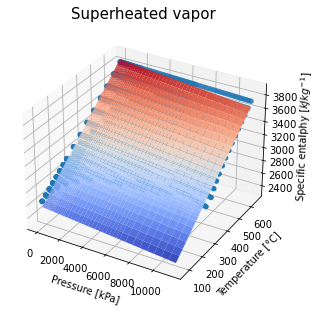

In [15]:
# - Plot LR and training data
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

x = H_data['Pressure']
y = np.array([int(H_data.columns[4:][i]) for i in range(len(H_data.columns[4:]))])

X,Y     = np.meshgrid(x,y)
Z       = H_data.loc[:, '75':'650']

ax.scatter(X, Y, Z.T)

# -- Predictions
LR_Predictions = LR_SV.predict(np.append(X.reshape(-1,1), Y.reshape(-1,1), axis=1)).reshape(X.shape)

ax.plot_surface(X, Y, LR_Predictions, cmap=cm.coolwarm)
ax.set_xlabel('Pressure [kPa]')
ax.set_ylabel('Temperature [°C]')
ax.set_zlabel('Specific entalphy [$kJ kg^{-1}$]')
ax.set_title('Superheated vapor', size=15)
plt.show()

In [16]:
###########  End of Linear Regression #################

## Polynomial regression (Generalised Linear Regression) using sklearn

So far we sectioned the data into three parts (in case of Saturated liquids) and we approximate each part with
linear regression. In this way, we obtained a discrete model for the whole range of pressures. This
type of discrete models can be sometimes troublesome when applied to optimization problems (e.g.
they have points where the gradient does not exist). Therefore, now we will try to construct a 
smooth model (without this discrete features) using polynomial regression.

The data is taken from this book: Introduction to Chemical Engineering Thermodynamics by J. M. Smith, H. C. Van Ness and M. M. Abbott, 7th Edition. Appendix F.

In [17]:

#Collecting Data in two variables
P = V_data['Pressure']
V = V_data['Liq_Sat']

P = np.array(P).reshape(-1,1)
V = np.array(V)

In [18]:
# Defining the basis functions: polynomials
feature_1 = P**2
feature_2 = P**3
feature_3 = P**4
feature_4 = P**5

new_features = [feature_1, feature_2, feature_3, feature_4]          # List of new features

In [19]:
Features = P
for new in new_features:
    Features    = np.append(Features, new, axis=1)

# scaling
ss          = StandardScaler()
scaler      = ss.fit(Features)
Features_ss = scaler.transform(Features)

# ------ Remember what the standarization is doing
print('  Mean: ', np.mean(Features_ss, axis=0))
print('\n Standard deviation: ', np.std(Features_ss, axis=0))

  Mean:  [-1.46941283e-16  1.20818388e-16 -2.05717796e-16  1.11022302e-16
 -6.53072367e-18]

 Standard deviation:  [1. 1. 1. 1. 1.]


Pipeline(steps=[('pf', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('LR', LinearRegression())])


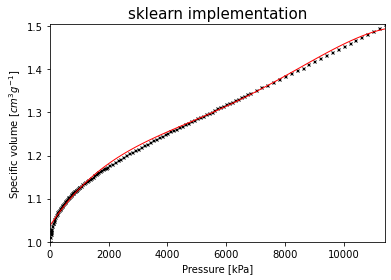

Parameters:  [ 0.          0.33238947 -0.63377876  0.71375797 -0.28213813]
Intercept :  1.2153823529411767


In [20]:
pf = PolynomialFeatures(degree=4, include_bias=True)
LR = LinearRegression()

# Define pipeline
PR_sklearn = Pipeline([("pf", pf), ("ss", ss), ("LR", LR),])
print(PR_sklearn)
PR_sklearn.fit(P, V)

# Plot polynomial prediction
evaluation_points = np.linspace(1e-8, P[-1], 100)
plt.figure()
plt.plot(P, V, 'kx', markersize=3)
plt.plot(evaluation_points, PR_sklearn.predict(evaluation_points), 'r', linewidth=1)
plt.title('sklearn implementation', size=15)
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific volume [$cm^3 g^{-1}$]')
plt.xlim((0, P[-1]))
plt.ylim((V[0], V[-1]))
plt.show()

# Print model parameters
print('Parameters: ', PR_sklearn['LR'].coef_)
print('Intercept : ', PR_sklearn['LR'].intercept_)

### Using a different base

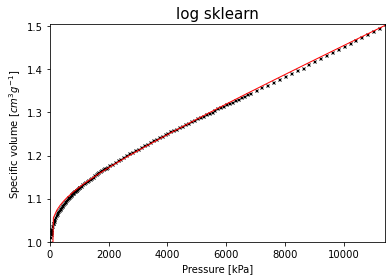

Parameters:  [0.10138431 0.0320854 ]
Intercept :  1.2153823529411765
R2 for polynomial regression: 0.998201429670517


In [21]:
class log_feature(BaseEstimator, TransformerMixin):
        
    def fit(self,X,y=None):
        return self
        
    def transform(self,X):
        X_log = np.log(X)
        X_new = np.hstack((X, X_log))
        return X_new

pf = log_feature()

# Define pipeline
PR_sklearn = Pipeline([("pf", pf), ("ss", ss), ("LR", LR), ])
PR_sklearn.fit(P, V)

# Plot polynomial prediction
plt.figure()
plt.plot(P, V, 'kx', markersize=3)
plt.plot(evaluation_points, PR_sklearn.predict(evaluation_points), 'r', linewidth=1)
plt.title('log sklearn', size=15)
plt.xlabel('Pressure [kPa]')
plt.ylabel('Specific volume [$cm^3 g^{-1}$]')
plt.xlim((0, P[-1]))
plt.ylim((V[0], V[-1]))
plt.show()

# Print model parameters
print('Parameters: ', PR_sklearn['LR'].coef_)
print('Intercept : ', PR_sklearn['LR'].intercept_)

# Print model performance
print('R2 for polynomial regression:', PR_sklearn.score(P, V))

**Note:** You can practice to build Linear regression model as well polynomial regression models on the remaining data that we didnot cover in the class.